# Requirements 

#### Based on TA's suggestion

- [x] pooled model
- [x] separate model
- [x] predictions
- [x] loo
- [ ] different prior, noninformative, change the prior? why did you select?
- [ ] sensitivity analysis, (change the prior)
- [ ] if loo indicates a bias, just report it


#### Based on Akki suggestion

- [ ] Description of the data, and the analysis problem
- [ ] Description of the model
- [ ] Description of the prior choices
- [ ] Stan code
- [ ] How Stan model is run
- [ ] Convergence diagnostics (Rhat, divergences, neff)
- [ ] Posterior predictive checking
- [ ] Model comparison (e.g. with loo)
- [ ] Predictive performance assessment if applicable (e.g. classification accuracy)
- [ ] Potentially sensitivity analysis
- [ ] Discussion of problems, and potential improvements


#### Based on Rubrics
Is there an introduction?
- [ ] The introduction is inviting, presents an overview of the notebook. Information is relevant and presented in a logical order.

Is there a conclusion?
- [ ] The conclusion is clear

The structure and organization of the notebook
- [ ] The notebook presents a clear cohesive data analysis story, which is enjoyable to read

The structure and organization of the notebook
- [ ] The notebook presents a clear cohesive data analysis story, which is enjoyable to read

Accuracy of use of statistical terms
- [ ] Statistical terms are used accurately but sometimes lack clarity – Statistical terms are used accurately and with clarity

Description of the data, and the analysis problem
- [ ] Did you get a sense of what is the data and the analysis problem when they were first
introduced? Where and how might the author make the model description more clear?

Description of the model
- [ ] Did you get a sense of what is the model? Where and how might the author make the model description more clear?

Description of the prior choices
- [ ] Priors are listed and justified

Is Stan code included?
- [x] yes

Is code for how Stan model is run included?
- [x] yes

Is required convergence diagnostics (Rhat, divergences, neff) included?
- [ ] Required convergence diagnostic results shown and maning of the results is discussed

Is there posterior predictive checking? 
- [ ] yes

Is there a discussion of problems and potential improvements ?
- [ ] yes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
from psis import psisloo

In [2]:
def plot_trend(x_axis, y_axis, tlitle=''):
    plt.plot(x_axis, y_axis)
    plt.rcParams['figure.figsize'] = (10,5)
    z = np.polyfit(x_axis, y_axis, 1)
    trend = np.poly1d(z)
    plt.plot(x_axis, trend(x_axis), 'r--')
    plt.xticks(np.arange(2004, 2018, 1))
    plt.xlabel('year')
    plt.ylabel('deaths')
    plt.title(tlitle)
    plt.show()

# Data preprocessing

In [3]:
def process_data():    
    data_years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
    for year in data_years:
        data = pd.read_csv(
            'data/project/csv/tieliikenneonnettomuudet_{0}_hlo.csv'.format(year), 
            sep=';', 
            encoding = "ISO-8859-1"
        )

        death = data.loc[data['Seuraussel'] == 'kuollut']
        gender = death['Sukupuoli'].values

        male = np.count_nonzero(gender == 'M')
        female = np.count_nonzero(gender == 'N')

        data = {'year': [year], 'male': [male], 'female': [female]}
        df = pd.DataFrame(data)

        df = df[['year', 'male', 'female']]
        df.to_csv('data/data.csv', mode='a', header=None, index=False)

# process_data()

## Number of death due to road traffic accidents in Finland

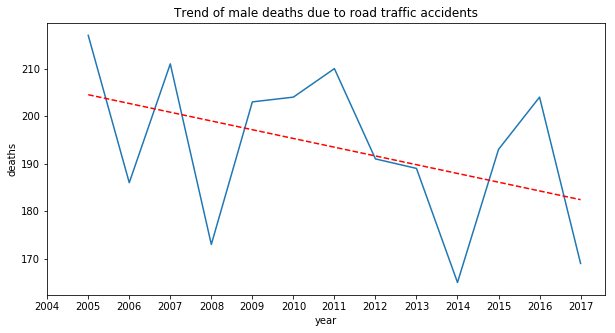

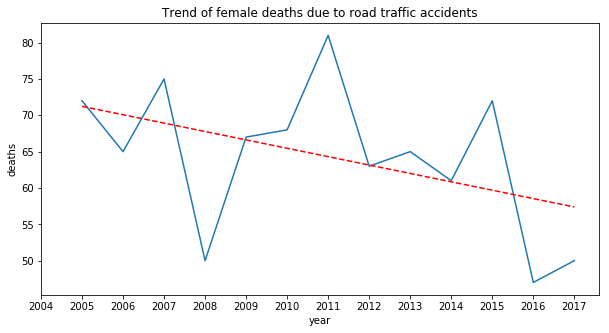

In [25]:
data = pd.read_csv('data/data.csv', sep = ',')
data['total']= data.iloc[:, 1:3].sum(axis=1)

years = data['year'].values
year_index = np.arange(1, len(years)+1)
male = data['male'].values
female = data['female'].values
total_deaths = data['total'].values
prediction_year = 14

mu = np.mean(total_deaths)
sigma = np.var(total_deaths)

# new params
N = len(total_deaths) * 2
num_groups = 2
x = np.arange(1, 3)
x = np.repeat(x, len(years))
group_indicator = np.arange(1, 3)
group_indicator = np.repeat(x, len(years))
combined = np.concatenate((male, female), axis=0)
plot_trend(years, male, 'Trend of male deaths due to road traffic accidents')
plot_trend(years, female, 'Trend of female deaths due to road traffic accidents')

# Models

# Pooled Model

In [151]:
# POOLED MODEL
pooled_factory_code = '''
data {
    int<lower=0> N;                 // number of data points
    real xpred;                     // year to predict
    vector[N] number_of_deaths;
    vector[N] years;
    real tau;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = alpha + (beta * years);
    
}

model {
    beta ~ normal(0, tau);
    
    for (i in 1:N)
        number_of_deaths[i] ~ normal(mu[i], sigma);
}

generated quantities {
    real new_pred;
    vector[N] log_lik;
    
    new_pred = normal_rng(alpha + beta * xpred, sigma);

    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[i], sigma);
}
'''

sm = pystan.StanModel(model_code = pooled_factory_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_842605992fc89e8207e689a4a3808165 NOW.


### Pooled model to predict number of death due to road traffic accidents for male

In [152]:
accidents_data = {
    'N': len(total_deaths),
    'number_of_deaths': total_deaths,
    'years': years,
    'xpred': 2018,
    'tau': 78.165
}

In [153]:
pooled_fit = sm.sampling(
    data = accidents_data,
    control = {'adapt_delta': 0.95, 'max_treedepth': 15}
)

In [154]:
def get_model_summary(model_fit):
    summary = model_fit.summary()
    summary = pd.DataFrame(
        summary['summary'], 
        columns=summary['summary_colnames'], 
        index=summary['summary_rownames']
    )

    log_lik = model_fit.extract(permuted=True)['log_lik']

    loo, loos, ks = psisloo(log_lik)
    print('PSIS-LOO value: {0}'.format(loo))

    S = np.shape(log_lik)[0]
    lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

    p_loocv = lppd - loo
    print('The effective number of parameters is: {0}'.format(p_loocv))

    print('K-hat values: {0}'.format(ks))

    return summary
    
get_model_summary(pooled_fit)

PSIS-LOO value: -61.05102328235749
The effective number of parameters is: 2.374609536129178
K-hat values: [0.33705889 0.1817334  0.28268141 0.60175423 0.03807422 0.00592064
 0.20403712 0.00732702 0.03191033 0.13014491 0.31295595 0.3088049
 0.1969116 ]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,6672.020975,116.873927,3836.711390,-941.611112,4195.820782,6644.604029,9130.880062,14327.160557,1077.663050,1.002039
beta,-3.189674,0.058118,1.907811,-7.000019,-4.411752,-3.175406,-1.958813,0.590694,1077.565124,1.002040
sigma,25.495985,0.196264,6.336563,16.586202,21.113684,24.293717,28.558518,41.845954,1042.380194,1.007403
mu[1],276.725062,0.365456,13.784151,249.848307,268.126426,276.722916,285.282915,305.024487,1422.619603,1.000908
mu[2],273.535388,0.310899,12.230966,249.540322,265.770867,273.442521,281.029869,298.489486,1547.688873,1.000682
mu[3],270.345714,0.257901,10.792115,248.745357,263.519612,270.254417,276.946723,292.753619,1751.084995,1.000398
mu[4],267.156040,0.207661,9.519582,247.870846,261.168057,267.123542,272.828780,286.779433,2101.487948,1.000062
mu[5],263.966366,0.164048,8.488500,246.661461,258.787376,264.059570,269.063280,281.384610,2677.431001,0.999718
mu[6],260.776693,0.133219,7.795273,244.620393,256.031803,260.835809,265.362895,276.645906,3423.972616,0.999483
mu[7],257.587019,0.121048,7.533753,242.156055,253.046541,257.721643,262.101513,272.973105,3873.521658,0.999511


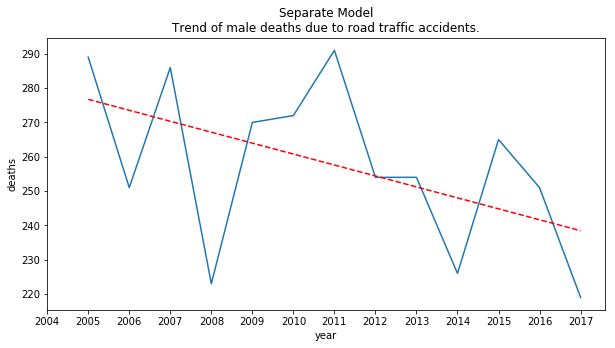

In [155]:
alpha = pooled_fit.extract()['alpha']
alpha = np.mean(alpha, axis=0)

beta = pooled_fit.extract()['beta']
beta = np.mean(beta, axis=0)

plt.plot(years, total_deaths)
plt.plot(years, [alpha + beta * i for i in range(2005, 2018)],  'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Separate Model\nTrend of male deaths due to road traffic accidents.')
plt.show()

In [125]:
def get_PSIS_LOO(model):
    """
    Get logposterior from the model, excluding the warmup perid
    Calculate the effective number of parameters p_eff
    Return PSIS-LOO estimates, p_eff
    """
    log_lik = model.extract(permuted=True)['log_lik']
    psis_loo, psis_loos_sep, k_values = psisloo(log_lik)
    
    lppd = np.sum(np.log(np.mean(np.exp(log_lik), axis=0)))
    p_eff = lppd - psis_loo
    
    return psis_loo, psis_loos_sep, k_values, p_eff

def quality_analysis(model):
    """
    Plots the resulting k_values
    """
    psis_loo, psis_loos_sep, k_values, p_eff = get_PSIS_LOO(model)
    
    print('PSIS-LOO estimate: {:.2f}\np_eff value: {:.2f}'.format(psis_loo, p_eff))
    
    pd.Series(k_values).plot(kind='bar', color='green', label='k-values', alpha=0.4)
    plt.title('K-values < 0.7: {0} out of {1}'.format(sum(k_values <= .7), len(k_values)))
    plt.hlines(0.7, -1, 30, label='0.7 threshhold', linestyles='dashed')
    plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.show()

PSIS-LOO estimate: -61.18
p_eff value: 2.46


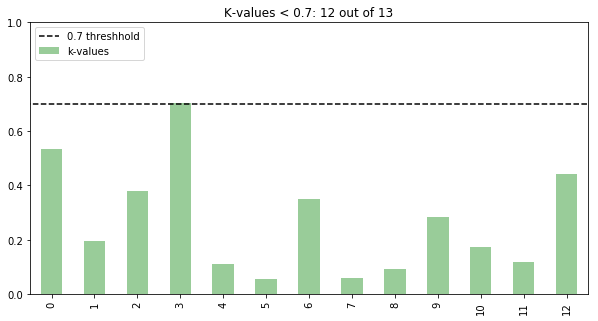

In [126]:
quality_analysis(pooled_fit)

### Predictions for 2018

In [40]:
def plot_perdiction_histogram(fit, xlim, xticks, bins, title='', ypred='ypred'):
    y_pred = fit.extract()[ypred]
    plt.hist(y_pred, bins=bins, ec='white', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])
    plt.xticks(np.arange(xlim[0], xlim[1], xticks))
    plt.title(title)
    plt.show()

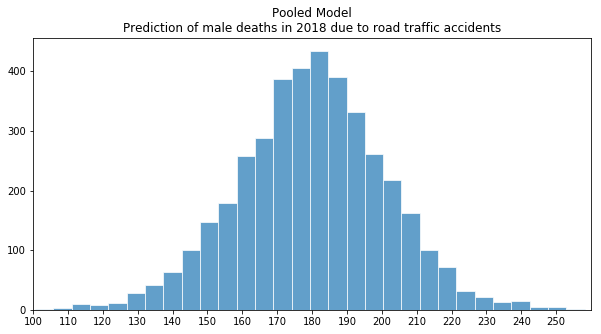

In [21]:
plot_perdiction_histogram(
    pooled_fit, 
    ypred='ypred',
    xlim=[100, 260], 
    xticks=10, 
    bins=40,
    title='Pooled Model\nPrediction of male deaths in 2018 due to road traffic accidents'
)

## Separate Model

In [138]:
# SEPARATE MODEL
accidents_code = '''
data {
    int<lower=0> N;                 // number of data points
    int<lower=0> K;                 // number of groups
    int<lower=1,upper=K> group[N];  // group indicator
    real xpred;                     // year to predict
    vector[N] number_of_deaths;
    vector[N] years; 
    vector[K] tau;
}

parameters {
    vector[K] alpha;
    vector[K] beta;
    vector<lower=0>[K] sigma;
}

transformed parameters{
    vector[N] mu;
    for (i in 1:N)
        mu[i] = alpha[group[i]] + beta[group[i]] * years[i];
}

model {
    beta[1] ~ normal(0, tau[1]);
    beta[2] ~ normal(0, tau[2]); 
    
    for (i in 1:N)
        number_of_deaths[i] ~ normal(mu[i], sigma[group[i]]);
}

generated quantities {
    real male_pred;
    real female_pred;
    vector[N] log_lik;

    male_pred = normal_rng(alpha[1] + beta[1] * xpred, sigma[1]);
    female_pred = normal_rng(alpha[2] + beta[2] * xpred, sigma[2]);

    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[i], sigma[group[i]]);
}
'''

sm = pystan.StanModel(model_code = accidents_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2540ac1bb6c4020a6657c7d23ffd014 NOW.


In [139]:
accidents_data = {
    'N': N,
    'K': num_groups,
    'group': x,
    'number_of_deaths': combined,
    'years': list(years)*2,
    'xpred': 2018,
    'tau': [58.806, 19.545]
}


separate_fit = sm.sampling(
    data = accidents_data,
    control = {'adapt_delta': 0.95, 'max_treedepth': 15}
)

### Separate model evaluation

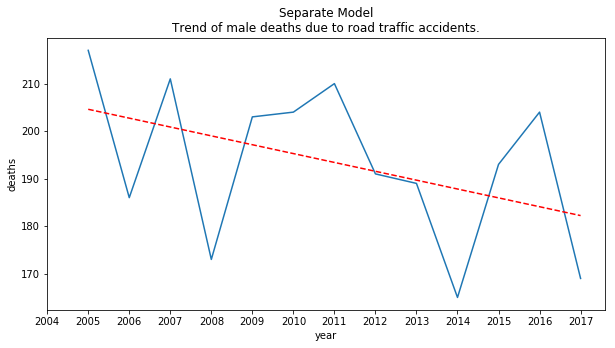

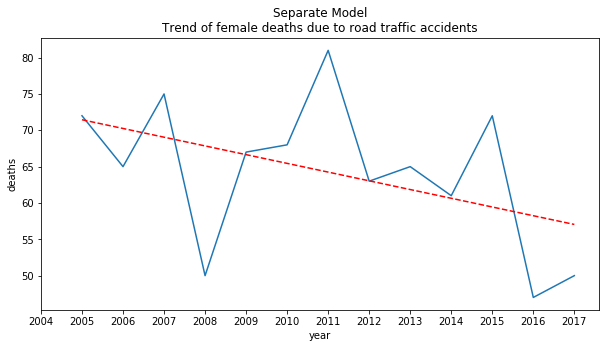

In [140]:
alpha = separate_fit.extract()['alpha']
alpha = np.mean(alpha, axis=0)

beta = separate_fit.extract()['beta']
beta = np.mean(beta, axis=0)

plt.plot(years, male)
plt.plot(years, [alpha[0] + beta[0] * i for i in range(2005, 2018)],  'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Separate Model\nTrend of male deaths due to road traffic accidents.')
plt.show()

plt.plot(years, female)
plt.plot(years, [alpha[1] + beta[1] * i for i in range(2005, 2018)], 'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Separate Model\nTrend of female deaths due to road traffic accidents')
plt.show()

PSIS-LOO estimate: -106.63
p_eff value: 4.92


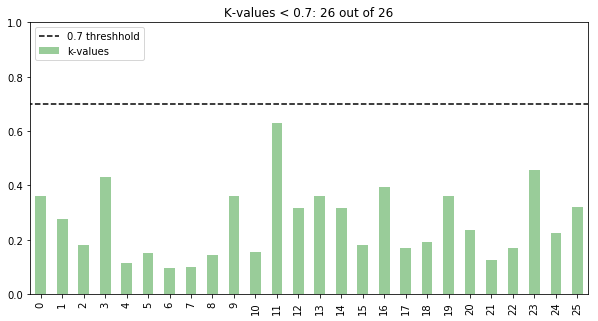

In [141]:
quality_analysis(separate_fit)

### Predictions for 2018

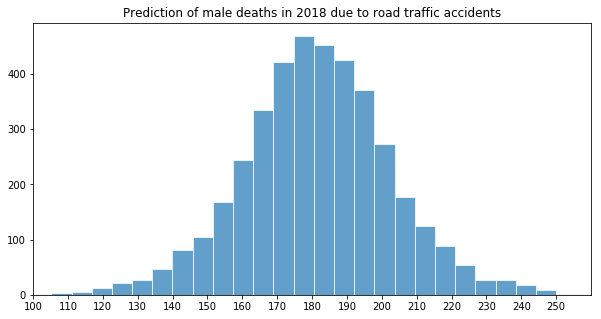

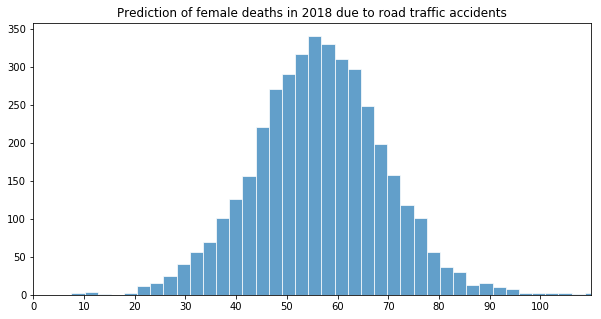

In [112]:
plot_perdiction_histogram(
    separate_fit, 
    ypred='male_pred',
    xlim=[100, 260], 
    xticks=10, 
    bins=40,
    title='Prediction of male deaths in 2018 due to road traffic accidents'
)

plot_perdiction_histogram(
    separate_fit, 
    ypred='female_pred',
    xlim=[0, 110], 
    xticks=10, 
    bins=40,
    title='Prediction of female deaths in 2018 due to road traffic accidents'
)

In [113]:
print('Prediction of male deaths in 2018:  \t {0}'.format( 
    round(np.mean(separate_fit.extract()['male_pred']))) 
 )
print('Prediction of female deaths in 2018:\t {0}'.format( 
    round(np.mean(separate_fit.extract()['female_pred']))) 
 )

Prediction of male deaths in 2018:  	 181.0
Prediction of female deaths in 2018:	 56.0


In [114]:
summary = separate_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = separate_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('K-hat values: {0}'.format(ks))

summary

PSIS-LOO value: -106.79483044445101
The effective number of parameters is: 4.969735570349712
K-hat values: [ 0.31912775  0.29122659  0.13673001  0.3440161   0.07440777  0.15673456
  0.21813668  0.20861199  0.19605219  0.53121499  0.16316869  0.44004844
  0.37587986  0.31837737  0.18513652  0.25792762  0.59239288 -0.05817798
 -0.04420176  0.44007228 -0.02122744 -0.08968854 -0.0760128   0.25766668
  0.49163181  0.40950333]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha[1],3785.474799,80.190762,2860.466309,-1771.531694,2085.061483,3756.324344,5449.301805,9607.014544,1272.403894,1.003201
alpha[2],2354.502223,43.276961,1587.680927,-842.260580,1361.901162,2354.915874,3355.534388,5587.470740,1345.900488,1.003382
beta[1],-1.786191,0.039872,1.422349,-4.683953,-2.614358,-1.772417,-0.940584,0.979325,1272.552721,1.003205
beta[2],-1.138884,0.021519,0.789483,-2.747492,-1.636240,-1.138984,-0.646221,0.448536,1345.981408,1.003382
sigma[1],18.228485,0.137179,4.955148,11.687699,14.849000,17.191101,20.591077,30.228207,1304.779456,1.002130
sigma[2],10.847979,0.065502,2.775330,6.917588,8.880547,10.358717,12.260196,17.916029,1795.256968,1.001035
mu[1],204.162678,0.259967,10.115796,184.335274,198.145448,203.978239,210.045531,224.541468,1514.132654,1.001341
mu[2],202.376487,0.222372,8.929856,184.918012,196.987242,202.226624,207.612516,220.280285,1612.602317,1.001016
mu[3],200.590297,0.185729,7.823138,185.121192,195.835799,200.474319,205.318637,216.118226,1774.202431,1.000617
mu[4],198.804106,0.150732,6.834238,185.349760,194.612738,198.722993,202.913805,212.429042,2055.737069,1.000161


<h2>DON'T TOUCH</h2>

In [ ]:
# POOLED MODEL
accidents_code = '''
data {
    int <lower=0> N;             //number of data points
    vector[N] year;              //observation year
    vector[N] number_of_deaths;  //total number of deaths
    real prediction_year;        //prediction year
    
    real mean_data;
    real variance_data;
}

parameters {
    real alpha;
    real beta;
    real <lower=0> sigma;
}

transformed parameters {
    vector[N] mu;
    mu = alpha + (beta * year);
}

model {
    beta ~ normal(mean_data, variance_data);
    number_of_deaths ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    real ypred;
    ypred = normal_rng(alpha + (beta * prediction_year), sigma);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu, sigma);
}
'''
model = pystan.StanModel(model_code=accidents_code)

In [ ]:
def stan_sampling_fit(deaths, years, year_to_predict):
    accidents_data = {
        'N': len(deaths),
        'year': years,
        'number_of_deaths': deaths,
        'prediction_year': year_to_predict,
        'mean_data': mu,
        'variance_data': sigma
    }
    return model.sampling(data = accidents_data, control = {'adapt_delta': 0.95, 'max_treedepth': 15})

In [ ]:
accidents_fit = stan_sampling_fit(total_deaths, years, prediction_year)
summary = accidents_fit.summary()
summary = pd.DataFrame(
    summary['summary'], 
    columns=summary['summary_colnames'], 
    index=summary['summary_rownames']
)

summary

In [ ]:
log_lik = accidents_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('KS value: {0}'.format(ks))

#### Predictions for total number of deaths in 2018

In [ ]:
def plot_perdiction_histogram(fit, xlim, xticks):
    y_pred = fit.extract()['ypred']
    plt.hist(y_pred, bins=40, ec='white', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])
    plt.xticks(xticks)
    plt.show()

In [ ]:
plot_perdiction_histogram(
    accidents_fit, 
    xlim=[120, 350], 
    xticks=np.arange(120, 360, 20)
)

## Male death due to road traffic accidents in Finland

In [ ]:
plot_trend(years, male)

In [ ]:
accidents_fit_male = stan_sampling_fit(male, years, prediction_year)
summary_male = accidents_fit_male.summary()
summary_male = pd.DataFrame(
    summary_male['summary'], 
    columns=summary_male['summary_colnames'], 
    index=summary_male['summary_rownames']
)

summary_male

#### Predictions for number of male deaths in 2018

In [ ]:
plot_perdiction_histogram(
    accidents_fit_male, 
    xlim=[110, 260], 
    xticks=np.arange(110, 260, 10)
)

## Female death due to road traffic accidents in Finland

In [ ]:
plot_trend(years, female)

In [ ]:
accidents_fit_female = stan_sampling_fit(female, years, prediction_year)
summary_female = accidents_fit_female.summary()
summary_female = pd.DataFrame(
    summary_female['summary'], 
    columns=summary_female['summary_colnames'], 
    index=summary_female['summary_rownames']
)

summary_female

### Predictions for number of female deaths in 2018

In [ ]:
plot_perdiction_histogram(
    accidents_fit_female, 
    xlim=[0, 110], 
    xticks=np.arange(0, 110, 10)
)